In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
data_dir = 'C:/Users/HP/Downloads/archive/dataset2-master/dataset2-master/images/TRAIN'
class_labels = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

In [3]:
filepaths = []
labels = []
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    for file in os.listdir(class_dir):
        if file.endswith('.jpeg') or file.endswith('.png') or file.endswith('.jpg'):
            filepaths.append(os.path.join(class_dir, file))
            labels.append(label)


In [4]:
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
print(f"Total images loaded: {len(df)}")
print(df['labels'].value_counts())

Total images loaded: 9957
labels
neutrophil    2499
eosinophil    2497
lymphocyte    2483
monocyte      2478
Name: count, dtype: int64


In [6]:
train_images, test_images = train_test_split(df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(train_set, x_col='filepaths', y_col='labels',
                                      target_size=(244, 244), class_mode='categorical',
                                      batch_size=8, shuffle=True)
val = image_gen.flow_from_dataframe(val_set, x_col='filepaths', y_col='labels',
                                    target_size=(244, 244), class_mode='categorical',
                                    batch_size=8, shuffle=False)
test = image_gen.flow_from_dataframe(test_images, x_col='filepaths', y_col='labels',
                                     target_size=(244, 244), class_mode='categorical',
                                     batch_size=8, shuffle=False)

Found 5575 validated image filenames belonging to 4 classes.
Found 1394 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.


In [8]:
base_model = MobileNetV2(input_shape=(244, 244, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(4, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



C:\Users\HP\AppData\Local\Temp\ipykernel_13252\1471734011.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(244, 244, 3), include_top=False, weights='imagenet')


In [9]:
history = model.fit(train, validation_data=val, epochs=10)



C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 233s 318ms/step - accuracy: 0.5572 - loss: 1.0660 - val_accuracy: 0.7468 - val_loss: 0.6318
Epoch 2/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 205s 294ms/step - accuracy: 0.7849 - loss: 0.5497 - val_accuracy: 0.7862 - val_loss: 0.5347
Epoch 3/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 210s 302ms/step - accuracy: 0.8357 - loss: 0.4114 - val_accuracy: 0.8321 - val_loss: 0.4227
Epoch 4/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 208s 298ms/step - accuracy: 0.8786 - loss: 0.3033 - val_accuracy: 0.8042 - val_loss: 0.4686
Epoch 5/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 204s 293ms/step - accuracy: 0.9059 - loss: 0.2527 - val_accuracy: 0.8831 - val_loss: 0.3113
Epoch 6/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 204s 292ms/step - accuracy: 0.9172 - loss: 0.2129 - val_accuracy: 0.8902 - val_loss: 0.2810
Epoch 7/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 203s 292ms/step - accuracy: 0.9427 - loss: 0.1568 - val_accuracy: 0.8113 - val_loss: 0.4956
Epoch 8/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 203s 291ms/step - accuracy: 0.9358 -

In [10]:
loss, accuracy = model.evaluate(test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')



374/374 ━━━━━━━━━━━━━━━━━━━━ 95s 254ms/step - accuracy: 0.8928 - loss: 0.3006
Test Accuracy: 88.45%


In [11]:
model.save('Blood_Cell.h5')


374/374 ━━━━━━━━━━━━━━━━━━━━ 92s 239ms/step
              precision    recall  f1-score   support

  eosinophil       0.75      0.94      0.83       679
  lymphocyte       0.92      0.98      0.95       777
    monocyte       0.95      0.97      0.96       759
  neutrophil       0.96      0.66      0.78       773

    accuracy                           0.88      2988
   macro avg       0.89      0.89      0.88      2988
weighted avg       0.90      0.88      0.88      2988



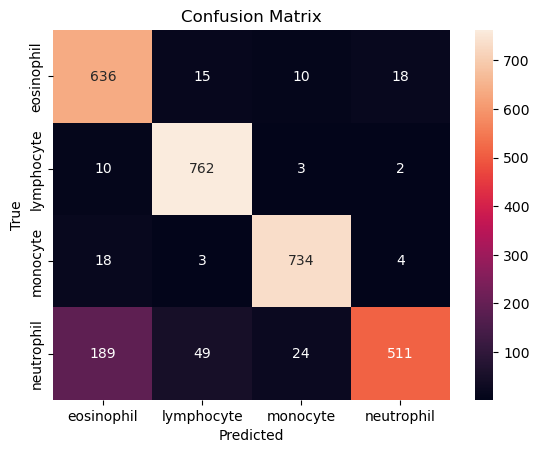

In [12]:
predictions = model.predict(test)
y_pred = np.argmax(predictions, axis=1)
y_true = test.classes
class_labels_list = list(test.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels_list))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels_list, yticklabels=class_labels_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
